# Kaggle fishery images

In [1]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load libraries
import os, time, json, re, copy
import itertools, collections
import argparse, pickle, random

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold

import io
import requests
import PIL
from PIL import Image
import cv2

from tqdm import tqdm, tqdm_notebook
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# plt.style.use('default')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
device = torch.device('cuda')
dtype = torch.cuda.FloatTensor

data_path = '/content'  # path of data files

In [0]:
# # For images saved in gdrive created from faster rcnn (didn't continue training classifier at the time)
# # cannot use cp -r due to so many items and taking long time...
# import os.path as osp
# from shutil import copyfile
# np.random.seed(0)

# im_path = '/content/drive/My Drive/DL_projects/cv_fish/Faster_RCNN/test_cls'
# if not os.path.exists('/content/test_cls'):
#     os.mkdir('/content/test_cls')

# files = os.listdir(im_path)
# np.random.shuffle(files)
# for imfile in files[:100]:
#     copyfile(osp.join(im_path, imfile), osp.join('/content/test_cls', imfile))

In [25]:
!ls

drive  fish_bbox  sample_data  train  train_cls


## Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [5]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f train.zip

 99% 826M/832M [00:20<00:00, 60.6MB/s]
100% 832M/832M [00:20<00:00, 43.0MB/s]


In [0]:
!unzip -q train.zip

In [0]:
!rm train.zip

In [0]:
!rm train/.DS_Store

In [0]:
!rm -r __MACOSX

In [0]:
!cp -r /content/drive/My\ Drive/DL_projects/Data/fish_monitor/fish_bbox ./

In [0]:
!mkdir train_cls

## Prepare data

In [0]:
label_clss = ['DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']
no_bbs = ['img_00568.jpg', 'img_01958.jpg', 'img_07008.jpg', 'img_00425.jpg',
          'img_04798.jpg', 'img_06460.jpg', 'img_02292.jpg', 'img_00576.jpg',
          'img_00379.jpg', 'img_06773.jpg', 'img_05444.jpg', 'img_06082.jpg',
          'img_03183.jpg', 'img_04558.jpg', 'img_02785.jpg']

In [0]:
!cp -r /content/train/NoF /content/train_cls/

In [0]:
for c in label_clss:
    if not os.path.exists(f'/content/train_cls/{c}'):
        os.mkdir(f'/content/train_cls/{c}')

In [0]:
gt = {}
for c in label_clss:
    with open(os.path.join(data_path, 'fish_bbox', c.lower()+'_labels.json')) as f:
        gt[c] = json.load(f)

all_files = []
for c in label_clss:
    im_files = os.listdir(os.path.join(data_path, 'train', c))
    all_files += [c+'/'+f for f in im_files if f not in no_bbs]

In [16]:
%%time
for fpath in all_files:
    im = Image.open(os.path.join(data_path, 'train', fpath))
    clss, fname = fpath.split('/')
    mask = list(map(lambda x: x['filename'].split('/')[-1]==fname, gt[clss]))
    bbs = np.array(gt[clss])[mask][0]['annotations']

    boxes = [[b['x'], b['y'], (b['x']+b['width']), (b['y']+b['height'])] for b in bbs]
    for i in range(len(boxes)):
        im.crop(boxes[i]).save(os.path.join(data_path, 'train_cls', clss, f'{i}_'+fname))

CPU times: user 55.1 s, sys: 829 ms, total: 55.9 s
Wall time: 56.1 s


In [17]:
import seaborn as sns
nb_each_class = {c:len(os.listdir(data_path+'/train_cls/'+c)) for c in os.listdir(data_path+'/train_cls')}
sns.barplot(x=pd.Series(nb_each_class).index, y=pd.Series(nb_each_class).values, color='royalblue');

In [18]:
nb_each_class

{'ALB': 2531,
 'BET': 307,
 'DOL': 124,
 'LAG': 101,
 'NoF': 465,
 'OTHER': 389,
 'SHARK': 196,
 'YFT': 823}

In [19]:
sum([len(os.listdir(os.path.join(data_path, 'train_cls', c))) for c in label_clss+['NoF']])

4936

In [0]:
# only keep some of the original images
np.random.seed(135)
files = os.listdir(os.path.join(data_path, 'train_cls', 'ALB'))
files_to_del = set(np.random.choice(files, int(len(files)*0.75), False))
for f in os.listdir(os.path.join(data_path, 'train_cls', 'ALB')):
    if f in files_to_del:
        os.remove(os.path.join(data_path, 'train_cls', 'ALB', f))

files = os.listdir(os.path.join(data_path, 'train_cls', 'YFT'))
files_to_del = set(np.random.choice(files, int(len(files)*0.25), False))
for f in os.listdir(os.path.join(data_path, 'train_cls', 'YFT')):
    if f in files_to_del:
        os.remove(os.path.join(data_path, 'train_cls', 'YFT', f))

In [21]:
import seaborn as sns
nb_each_class = {c:len(os.listdir(data_path+'/train_cls/'+c)) for c in os.listdir(data_path+'/train_cls')}
sns.barplot(x=pd.Series(nb_each_class).index, y=pd.Series(nb_each_class).values, color='royalblue');

In [22]:
sum([len(os.listdir(os.path.join(data_path, 'train_cls', c))) for c in label_clss+['NoF']])

2833

## Load data

In [0]:
# Label map
label_clss = ['NoF', 'DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']
clss_to_label = {c:i for i,c in enumerate(label_clss)}

# Model parameters
n_classes = len(label_clss)

# Learning parameters
batch_size = 32  # batch size

In [0]:
rgb_mean = [0.485, 0.456, 0.406]
rgb_std = [0.229, 0.224, 0.225]

tsfm_trn = T.Compose([
                    T.Resize((224, 224)),
                    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
                    T.RandomHorizontalFlip(),
                    T.RandomAffine(degrees=10, shear=10),
                    T.ToTensor(),
                    T.Normalize(rgb_mean, rgb_std),
                ])

tsfm_trn_nof = T.Compose([
                    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
                    T.RandomResizedCrop(224, scale=(0.1, 1.0)),
                    T.RandomHorizontalFlip(),
                    T.RandomAffine(degrees=10, shear=10),
                    T.ToTensor(),
                    T.Normalize(rgb_mean, rgb_std),
                ])

tsfm_test = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(rgb_mean, rgb_std),
        ])


class NCFMclass(Dataset):

    def __init__(self, path, split, which_fold=0, nb_folds=5, transform=None, seed=135):
        """
        :param path: path where data files are stored
        :param split: split, one of 'TRAIN', 'VALID', or 'TEST'
        """
        self.path = path
        self.split = split.upper()
        assert self.split in {'TRAIN', 'VALID', 'TEST'}
        self.transform = transform

        # Train/val split
        if self.split in {'TRAIN', 'VALID'}:
            train_files = []
            valid_files = []
            np.random.seed(seed)
            for c in label_clss:
                im_files = os.listdir(os.path.join(path, 'train_cls', c))
                
                nb_per_fold = len(im_files) // nb_folds
                val_indices = list(range(which_fold*nb_per_fold, which_fold*nb_per_fold+nb_per_fold))
                trn_indices = list(set(range(len(im_files))) - set(val_indices))
                
                np.random.shuffle(im_files)
                train_files += [c+'/'+f for f in np.array(im_files)[trn_indices]]
                valid_files += [c+'/'+f for f in np.array(im_files)[val_indices]]

            # Set files
            self.files = train_files if self.split == 'TRAIN' else valid_files
        
        else:
            self.files = os.listdir(os.path.join(path, 'test_cls'))

    def __getitem__(self, i):
        # Read image
        if self.split == 'TEST':
            image = Image.open(os.path.join(self.path, 'test_cls', self.files[i]), mode='r')
            image = image.convert('RGB')
            if self.transform is None: self.transform = tsfm_test
            return self.transform(image), self.files[i]
        
        image = Image.open(os.path.join(self.path, 'train_cls', self.files[i]), mode='r')
        image = image.convert('RGB')
        if self.transform is None:
            if self.split == 'TRAIN':
                if self.files[i].split('/')[0] == 'NoF':
                    self.transform = tsfm_trn_nof
                else:
                    self.transform = tsfm_trn
            else:
                self.transform = tsfm_test

        # Read label
        label = clss_to_label[self.files[i].split('/')[0]]

        return self.transform(image), torch.LongTensor([label])

    def __len__(self):
        return len(self.files)

In [0]:
val_dataset = NCFMclass(data_path, split='valid', which_fold=0, nb_folds=10)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Load model

In [0]:
dtype = torch.cuda.FloatTensor

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, output_size=None):
        "Output will be 2*output_size or 2 if output_size is None"
        super().__init__()
        self.output_size = output_size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class ResNetFish(nn.Module):
    def __init__(self, net):
        super().__init__()
        adapt_pool = AdaptiveConcatPool2d((1,1))
        flatten = Flatten()
        fc = nn.Linear(in_features=2048*2, out_features=8)
        nn.init.xavier_uniform_(fc.weight)
        nn.init.constant_(fc.bias, 0.)
        
        self.group_1 = nn.Sequential(*[c for c in net.children()][:5])
        self.group_2 = nn.Sequential(*[c for c in net.children()][5:8])
        self.group_3 = nn.Sequential(adapt_pool, flatten, fc)
    
    def forward(self, x):
        x = self.group_1(x)
        x = self.group_2(x)
        out = self.group_3(x)
        return out

def load_model():
    net = models.resnet50(pretrained=True)
    model = ResNetFish(net)
    model.load_state_dict(torch.load('/content/drive/My Drive/DL_projects/cv_fish/rn50_ft_epk_3_pl.pth'))
    return model

In [25]:
net = load_model()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


## Evaluation

In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def validate(val_loader, model):
    """
    One epoch's validation.

    :param val_loader: DataLoader for validation data
    :param model: model

    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    losses = AverageMeter()
    accs = AverageMeter()
    scores = []
    predictions = []
    targets = []

    with torch.no_grad():
        # Batches
        for i, (images, labels) in enumerate(tqdm_notebook(val_loader)):

            # Move to default device
            images = images.to(device)  # (N, 3, 224, 224)
            labels = labels.squeeze().to(device)

            # Forward prop.
            predicted_score = model(images)  # (N, n_classes)
            score = F.softmax(predicted_score, dim=1)
            _, preds = score.max(1)

            # Loss
            loss = F.cross_entropy(predicted_score, labels)
            losses.update(loss.item(), images.size(0))
            
            # Accuracy
            acc = float((preds == labels).sum()) / images.size(0)
            accs.update(acc, images.size(0))

            scores.append(score.cpu().numpy())
            predictions.append(preds.cpu().numpy())
            targets.append(labels.cpu().numpy())
            
    print('* Val Loss - {loss.avg:.3f}'.format(loss=losses))
    print('* Val Acc - {acc.avg:.3f}'.format(acc=accs))
    scores = np.concatenate(scores)
    targets = np.concatenate(targets)
    predictions = np.concatenate(predictions)

    return scores, predictions, targets


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype('float') / cm.sum().astype(np.float32)
    # print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, '{:.4f}'.format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
val_scores, val_preds, val_y = validate(val_loader, net.to(device))


* Val Loss - 0.698
* Val Acc - 0.789


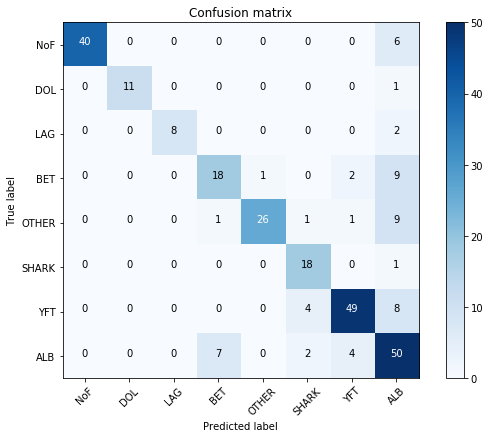

In [59]:
cm = confusion_matrix(val_y, val_preds)
plot_confusion_matrix(cm, label_clss)

In [0]:
precision_each_class, recall_each_class = {}, {}
for i,c in enumerate(label_clss):
    p = cm[i,i] / (cm[:,i].sum())
    r = cm[i,i] / (cm[i,:].sum())
    precision_each_class[c] = p
    recall_each_class[c] = r

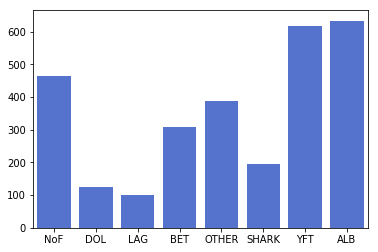

In [30]:
nb_each_class = {c:len(os.listdir(data_path+'/train_cls/'+c)) for c in label_clss}
sns.barplot(x=pd.Series(nb_each_class).index, y=pd.Series(nb_each_class).values, color='royalblue');

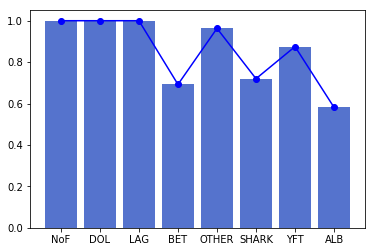

In [31]:
sns.barplot(x=pd.Series(precision_each_class).index, y=pd.Series(precision_each_class).values, color='royalblue')
plt.plot(pd.Series(precision_each_class).index, pd.Series(precision_each_class).values, '-bo');

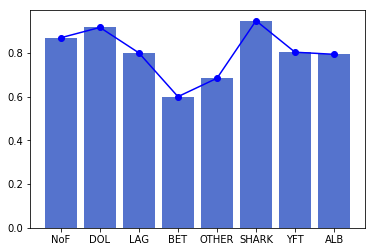

In [32]:
sns.barplot(x=pd.Series(recall_each_class).index, y=pd.Series(recall_each_class).values, color='royalblue')
plt.plot(pd.Series(recall_each_class).index, pd.Series(recall_each_class).values, '-bo');

In [0]:
def cor_incor_idx(c):
    ones_idx = np.where(val_y==c)[0]
    zeros_idx = np.where(val_y!=c)[0]

    TP_idx = ones_idx[np.where(val_preds[ones_idx]==c)[0]]
    FP_idx = zeros_idx[np.where(val_preds[zeros_idx]==c)[0]]
    FN_idx = ones_idx[np.where(val_preds[ones_idx]!=c)[0]]
    return TP_idx, FP_idx, FN_idx

## Visualization (grad-CAM)

In [0]:
# load image
def read_rand_img(idxs):
    selected_idx = np.random.choice(idxs, 1)[0]
    f = val_dataset.files[selected_idx]
    img = Image.open(os.path.join(data_path,'train_cls',f))
    return img, selected_idx

# preprocess input images
def preprocess(img):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

# compute gradients
def compute_backprop(X, y, model):
    """input: tensors X, y; pytorch model"""
    model.eval()
    scores = model(X)
    correct_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    loss = correct_scores.sum()
    loss.backward()

# forward propagation for inference
def get_preds(img, model):
    """input img tensor, pytorch model"""
    model.eval()
    logit = model(img)   # (1, 8)
    h_x = F.softmax(logit, dim=1).data.squeeze()   # (8,) probability of each class for this image
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()
    return probs, idx

In [0]:
# feature extractor
def extract_feature(x):
    net.eval()
    return net.group_2(net.group_1(x))

class Net_classifier(nn.Module):
    def forward(self, x): return net.group_3(x)

class GradCAM(nn.Module):
    def __init__(self):
        super(GradCAM, self).__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, feature_maps, feature_grads):
        # features size: (1, k, h, w)
        map_weights = self.ap(feature_grads)   # (1, k, 1, 1)
        maps = torch.sum(map_weights * feature_maps, 1)   # (1, h, w)
        grad_cam = F.relu(maps.squeeze(0))
        return grad_cam

def imresize(img, size):
    im = Image.fromarray(img)
    return np.array(im.resize(size, PIL.Image.BICUBIC))

def returnCAM(feature_maps, class_idx):
    # generate the class activation maps (CAMs) upsample to 256x256
    size_upsample = (256, 256)
    net_classifier = Net_classifier()
    
    feature_maps = feature_maps.type(dtype)
    feature_maps.requires_grad_()

    output_cam = []
    for idx in class_idx:
        compute_backprop(feature_maps, torch.cuda.LongTensor([idx]), net_classifier)
        gradCAM = GradCAM()
        cam = gradCAM(feature_maps, feature_maps.grad).detach().cpu().numpy()
        cam = cam - cam.min()
        cam = cam / cam.max() if cam.max() > 0 else cam
        cam = np.uint8(255 * cam)
        output_cam.append(imresize(cam, size_upsample))
    return output_cam

### ALB

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['ALB'])

In [48]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((50,), (36,), (13,))

In [54]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)

In [56]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 6, 4, 0, 1])

In [57]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.581 -> ALB
0.136 -> YFT
0.062 -> OTHER
0.060 -> NoF
0.058 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

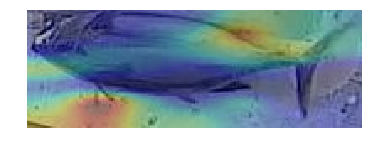

In [59]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

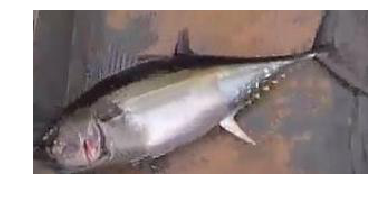

In [0]:
img_pil, _ = read_rand_img('ALB', TP_idx)

plt.axis('off')
plt.imshow(img_pil)

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)

In [0]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 6, 4, 0, 3])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.830 -> ALB
0.073 -> YFT
0.037 -> OTHER
0.032 -> NoF
0.009 -> BET


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

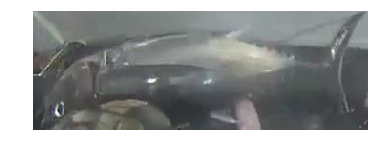

In [61]:
img_pil, _ = read_rand_img(FP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)

In [63]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 4, 3, 6, 5])

In [64]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.664 -> ALB
0.171 -> OTHER
0.048 -> BET
0.039 -> YFT
0.031 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[2]])

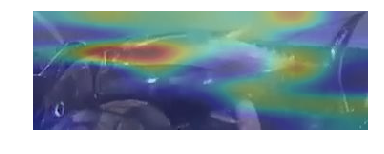

In [66]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

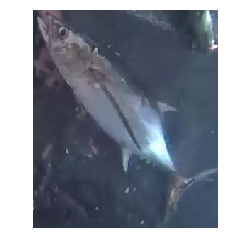

In [82]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)

In [84]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([3, 7, 4, 6, 5])

In [85]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.317 -> BET
0.285 -> ALB
0.201 -> OTHER
0.118 -> YFT
0.041 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

In [87]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### YFT

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['YFT'])

In [90]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((49,), (7,), (12,))

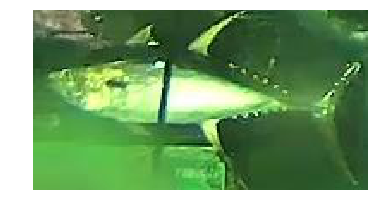

In [115]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [116]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([6, 7, 4, 5, 0])

In [117]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.970 -> YFT
0.017 -> ALB
0.005 -> OTHER
0.003 -> SHARK
0.002 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

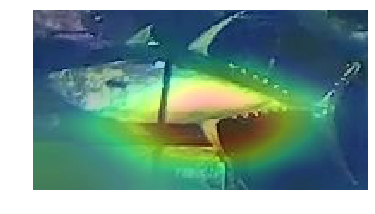

In [119]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

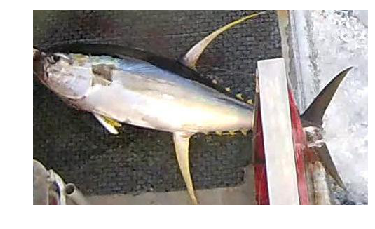

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([6, 7, 5, 1, 0])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.818 -> YFT
0.110 -> ALB
0.032 -> SHARK
0.014 -> DOL
0.012 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

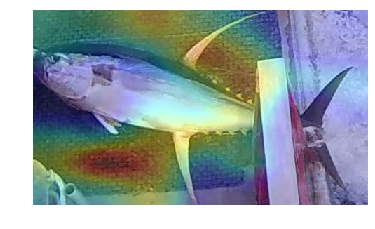

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

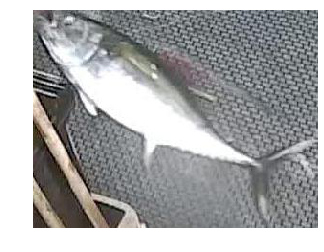

In [131]:
img_pil, _ = read_rand_img(FP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [132]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([6, 3, 7, 4, 5])

In [133]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.374 -> YFT
0.245 -> BET
0.240 -> ALB
0.059 -> OTHER
0.046 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

In [135]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### DOL

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['DOL'])

In [137]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((11,), (0,), (1,))

In [146]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [147]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([1, 0, 7, 3, 4])

In [148]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.860 -> DOL
0.037 -> NoF
0.036 -> ALB
0.023 -> BET
0.017 -> OTHER


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

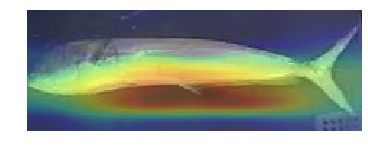

In [150]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

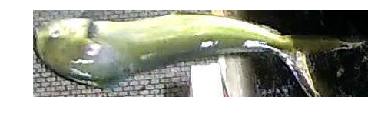

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([1, 7, 6, 0, 4])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.389 -> DOL
0.218 -> ALB
0.161 -> YFT
0.096 -> NoF
0.071 -> OTHER


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

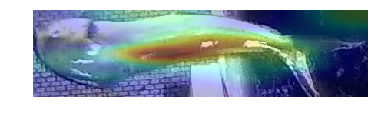

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

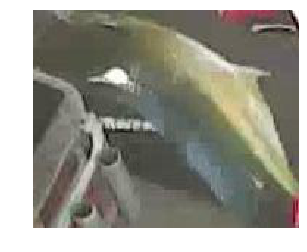

In [151]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [152]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 3, 6, 1, 0])

In [153]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.351 -> ALB
0.347 -> BET
0.123 -> YFT
0.068 -> DOL
0.045 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

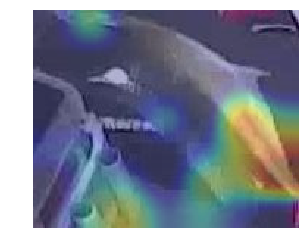

In [155]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### LAG

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['LAG'])

In [157]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((8,), (0,), (2,))

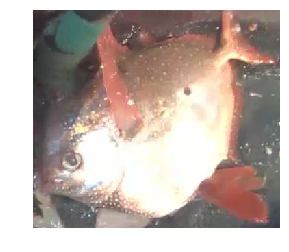

In [159]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [160]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([2, 7, 6, 4, 1])

In [161]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.683 -> LAG
0.200 -> ALB
0.037 -> YFT
0.034 -> OTHER
0.021 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

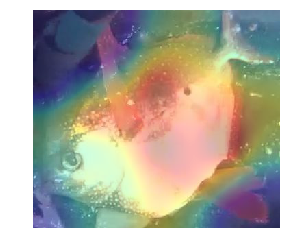

In [163]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

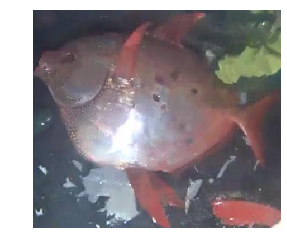

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([2, 7, 3, 6, 1])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.918 -> LAG
0.039 -> ALB
0.025 -> BET
0.008 -> YFT
0.003 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

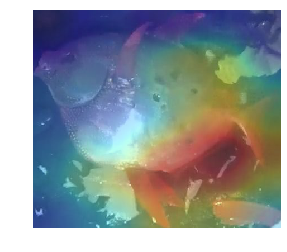

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

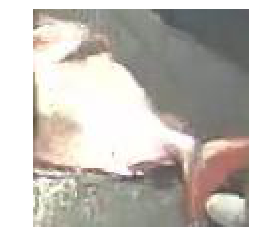

In [171]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [172]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 6, 0, 5, 3])

In [173]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.522 -> ALB
0.195 -> YFT
0.078 -> NoF
0.058 -> SHARK
0.047 -> BET


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

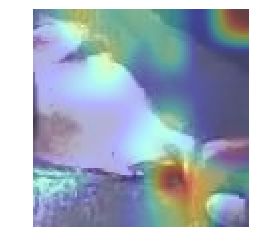

In [175]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### SHARK

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['SHARK'])

In [177]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((18,), (7,), (1,))

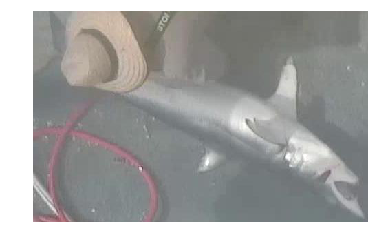

In [193]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [194]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([5, 7, 6, 4, 0])

In [195]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.859 -> SHARK
0.075 -> ALB
0.041 -> YFT
0.013 -> OTHER
0.005 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

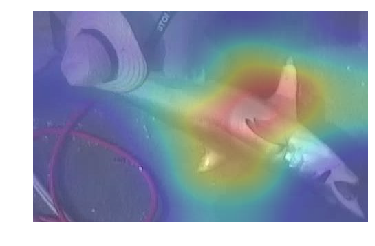

In [197]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

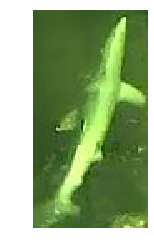

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([5, 7, 6, 4, 3])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.875 -> SHARK
0.078 -> ALB
0.024 -> YFT
0.018 -> OTHER
0.002 -> BET


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

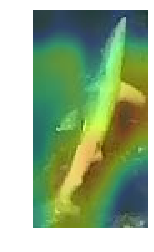

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

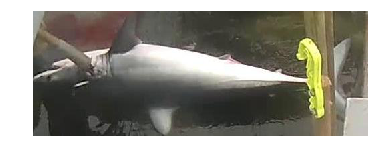

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([5, 6, 7, 4, 1])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.933 -> SHARK
0.040 -> YFT
0.010 -> ALB
0.007 -> OTHER
0.004 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

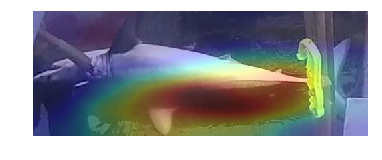

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

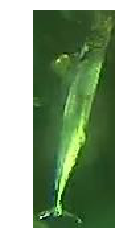

In [198]:
img_pil, _ = read_rand_img(FP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [199]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([5, 7, 4, 6, 1])

In [200]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.530 -> SHARK
0.195 -> ALB
0.130 -> OTHER
0.076 -> YFT
0.038 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

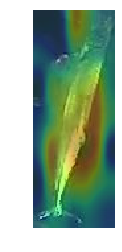

In [202]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

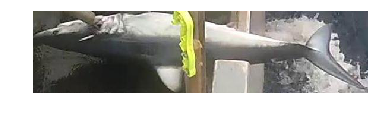

In [203]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [204]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 5, 3, 6, 0])

In [205]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.431 -> ALB
0.343 -> SHARK
0.107 -> BET
0.056 -> YFT
0.032 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

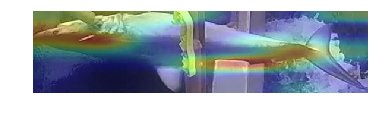

In [207]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### BET

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['BET'])

In [209]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((18,), (8,), (12,))

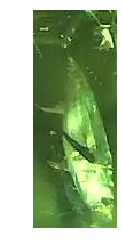

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 3, 4, 5, 6])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.411 -> ALB
0.218 -> BET
0.141 -> OTHER
0.116 -> SHARK
0.094 -> YFT


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

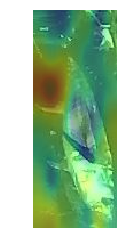

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

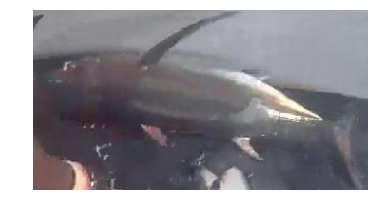

In [211]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [212]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([3, 6, 7, 4, 0])

In [213]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.572 -> BET
0.178 -> YFT
0.171 -> ALB
0.052 -> OTHER
0.010 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

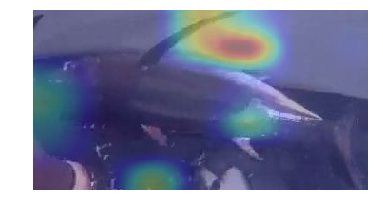

In [215]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

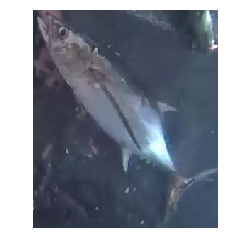

In [216]:
img_pil, _ = read_rand_img(FP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [217]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([3, 7, 4, 6, 5])

In [218]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.317 -> BET
0.285 -> ALB
0.201 -> OTHER
0.118 -> YFT
0.041 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

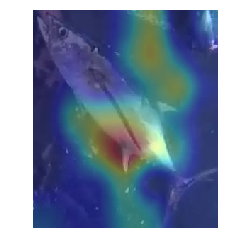

In [220]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

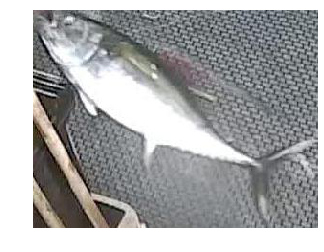

In [226]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [227]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([6, 3, 7, 4, 5])

In [228]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.374 -> YFT
0.245 -> BET
0.240 -> ALB
0.059 -> OTHER
0.046 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

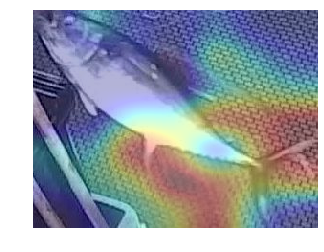

In [230]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### OTHER

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['OTHER'])

In [232]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((26,), (1,), (12,))

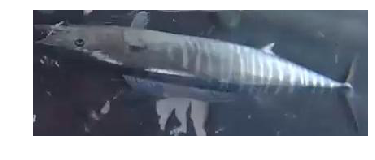

In [233]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [234]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([4, 3, 7, 6, 1])

In [235]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.866 -> OTHER
0.061 -> BET
0.046 -> ALB
0.011 -> YFT
0.006 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

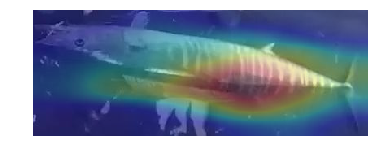

In [237]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

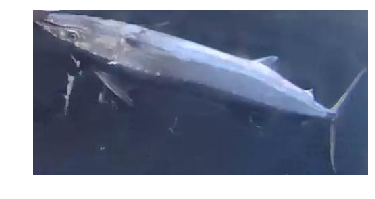

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([4, 7, 3, 5, 1])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.971 -> OTHER
0.010 -> ALB
0.009 -> BET
0.005 -> SHARK
0.001 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

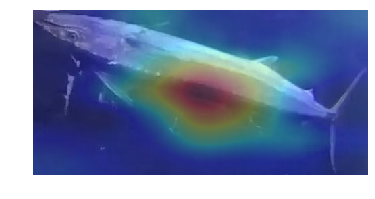

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

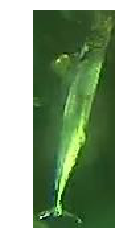

In [238]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [239]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([5, 7, 4, 6, 1])

In [240]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.530 -> SHARK
0.195 -> ALB
0.130 -> OTHER
0.076 -> YFT
0.038 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

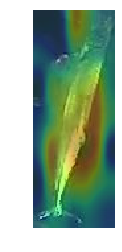

In [242]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### NoF

In [0]:
TP_idx, FP_idx, FN_idx = cor_incor_idx(clss_to_label['NoF'])

In [244]:
TP_idx.shape, FP_idx.shape, FN_idx.shape

((40,), (0,), (6,))

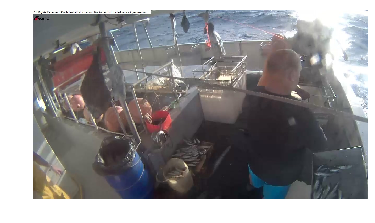

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([0, 7, 1, 6, 4])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.756 -> NoF
0.156 -> ALB
0.028 -> DOL
0.023 -> YFT
0.022 -> OTHER


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

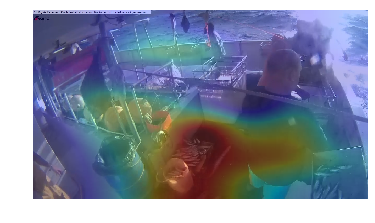

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

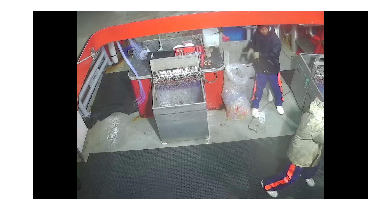

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([0, 7, 4, 1, 6])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.994 -> NoF
0.004 -> ALB
0.001 -> OTHER
0.001 -> DOL
0.001 -> YFT


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[2]])

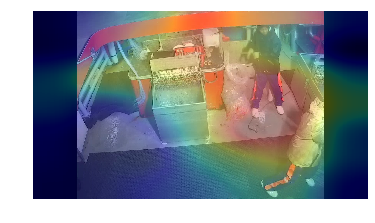

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

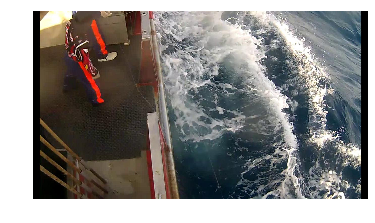

In [0]:
img_pil, _ = read_rand_img(TP_idx)

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([0, 7, 3, 1, 6])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.716 -> NoF
0.099 -> ALB
0.050 -> BET
0.049 -> DOL
0.045 -> YFT


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

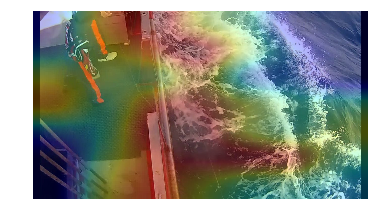

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

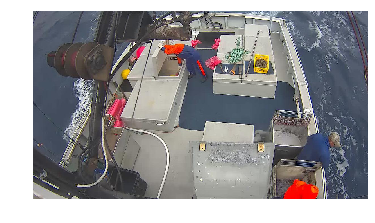

In [250]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [251]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 0, 6, 4, 3])

In [252]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.469 -> ALB
0.221 -> NoF
0.150 -> YFT
0.088 -> OTHER
0.025 -> BET


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

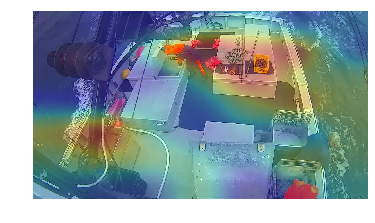

In [254]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

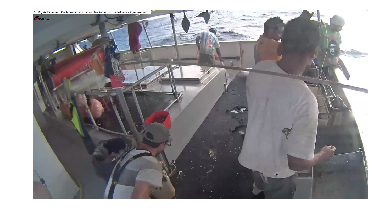

In [265]:
img_pil, _ = read_rand_img(FN_idx)

plt.axis('off')
plt.imshow(img_pil);

In [266]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 0, 3, 6, 1])

In [267]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.379 -> ALB
0.372 -> NoF
0.120 -> BET
0.059 -> YFT
0.030 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

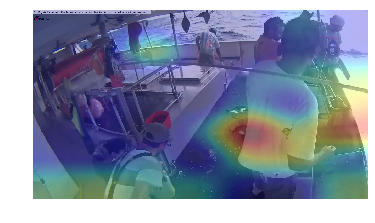

In [269]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()